<a href="https://colab.research.google.com/github/HanselWilfred/WeatherWise-Hansel-Wilfred/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [7]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install requests matplotlib pyinputplus





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ...

In [1]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

KeyboardInterrupt: Interrupted by user

## 📦 Setup and Configuration
Import required packages and setup environment.

In [8]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
#from hands_on_ai.chat import get_response

# Add any other setup code here

## 🌤️ Weather Data Functions

In [9]:
import requests

def get_weather_data(location_or_pin):
    # Use Open-Meteo geocoding API
    geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={location_or_pin}&count=1"
    geo_data = requests.get(geo_url).json()

    if "results" not in geo_data or not geo_data["results"]:
        return {"error": "Location not found. Try a different city or PIN code."}

    lat = geo_data["results"][0]["latitude"]
    lon = geo_data["results"][0]["longitude"]
    city_name = geo_data["results"][0]["name"]

    # Fetch weather for that exact lat/lon
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true&daily=temperature_2m_max,temperature_2m_min,precipitation_probability_max&timezone=auto"
    data = requests.get(url).json()

    return {
        "location": city_name,
        "current_temp": data["current_weather"]["temperature"],
        "forecast": [
            {
                "date": data["daily"]["time"][i],
                "max_temp": data["daily"]["temperature_2m_max"][i],
                "min_temp": data["daily"]["temperature_2m_min"][i],
                "rain_chance": data["daily"]["precipitation_probability_max"][i]
            }
            for i in range(5)
        ]
    }



## 📊 Visualisation Functions

In [10]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data):
    dates = [f["date"] for f in weather_data["forecast"]]
    max_temps = [f["max_temp"] for f in weather_data["forecast"]]
    min_temps = [f["min_temp"] for f in weather_data["forecast"]]

    plt.plot(dates, max_temps, marker="o", label="Max Temp")
    plt.plot(dates, min_temps, marker="o", label="Min Temp")
    plt.title(f"Temperature Forecast - {weather_data['location']}")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:

def create_precipitation_visualisation(weather_data):
    dates = [f["date"] for f in weather_data["forecast"]]
    rain = [f["rain_chance"] for f in weather_data["forecast"]]

    plt.bar(dates, rain, color="skyblue")
    plt.title(f"Rain Chance Forecast - {weather_data['location']}")
    plt.xlabel("Date")
    plt.ylabel("Rain Chance (%)")
    plt.show()


## 🤖 Natural Language Processing

In [12]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    question = question.lower()

    parsed = {
        "location": "Perth",
        "day": 0,
        "attribute": "rain"
    }

    if "tomorrow" in question:
        parsed["day"] = 1
    elif "day after" in question:
        parsed["day"] = 2

    if "temperature" in question or "hot" in question or "cold" in question:
        parsed["attribute"] = "temperature"
    elif "rain" in question or "precipitation" in question:
        parsed["attribute"] = "rain"

    if "sydney" in question:
        parsed["location"] = "Sydney"
    elif "melbourne" in question:
        parsed["location"] = "Melbourne"

    return parsed


def generate_weather_response(parsed_question, weather_data):
    day = parsed_question["day"]
    attribute = parsed_question["attribute"]

    if day >= len(weather_data["forecast"]):
        return "Sorry, I only have 5 days of forecast."

    forecast = weather_data["forecast"][day]

    if attribute == "temperature":
        return (f"On {forecast['date']} in {weather_data['location']}, "
                f"the temperature will be between {forecast['min_temp']}°C and {forecast['max_temp']}°C.")
    elif attribute == "rain":
        return (f"On {forecast['date']} in {weather_data['location']}, "
                f"the chance of rain is {forecast['rain_chance']}%.")
    else:
        return "I didn’t understand your question."


## 🧭 User Interface

In [13]:
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip

def main_menu():
    while True:
        choice = pyip.inputMenu(
            ["View Forecast", "Ask a Question", "Visualise Data", "Exit"],
            numbered=True
        )

        if choice == "View Forecast":
            location = pyip.inputStr("Enter a city: ")
            weather = get_weather_data(location)
            print(f"📍 {weather['location']} | 🌡️ {weather['current_temp']}°C")
            for f in weather["forecast"]:
                print(f"{f['date']}: {f['min_temp']}–{f['max_temp']}°C, Rain chance {f['rain_chance']}%")

        elif choice == "Ask a Question":
            q = pyip.inputStr("Ask me about the weather: ")
            parsed = parse_weather_question(q)
            data = get_weather_data(parsed["location"])
            print("🤖", generate_weather_response(parsed, data))

        elif choice == "Visualise Data":
            location = pyip.inputStr("Enter a city for charts: ")
            weather = get_weather_data(location)
            create_temperature_visualisation(weather)
            create_precipitation_visualisation(weather)

        elif choice == "Exit":
            print("Goodbye!")
            break


## 🧩 Main Application Logic

In [16]:
# Tie everything together here
def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 You can enter either a city name (e.g., Perth, Sydney) OR a PIN/ZIP code (e.g., 6000, 10001).")
    main_menu()



## 🧪 Testing and Examples

🌦️ Welcome to WeatherWise 🌦️
👉 You can enter either a city name (e.g., Perth, Sydney) OR a PIN/ZIP code (e.g., 6000, 10001).
Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit
94513
'94513' is not a valid choice.
Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit
1
Enter a city: 94513
📍 Brentwood | 🌡️ 27.7°C
2025-09-16: 16.0–36.6°C, Rain chance 0%
2025-09-17: 19.0–36.6°C, Rain chance 1%
2025-09-18: 18.9–31.5°C, Rain chance 23%
2025-09-19: 19.1–31.6°C, Rain chance 33%
2025-09-20: 16.0–35.0°C, Rain chance 4%
Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit
3
Enter a city for charts: 94513


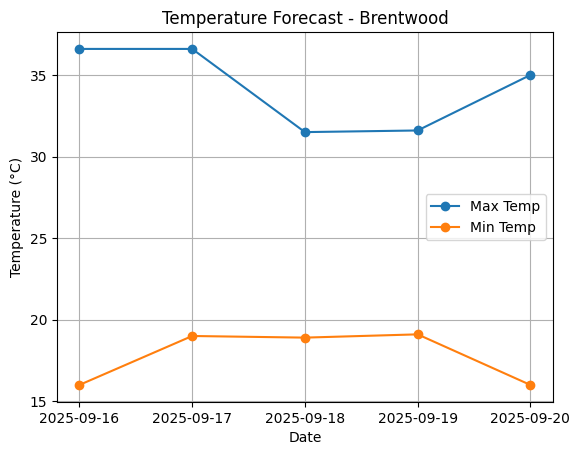

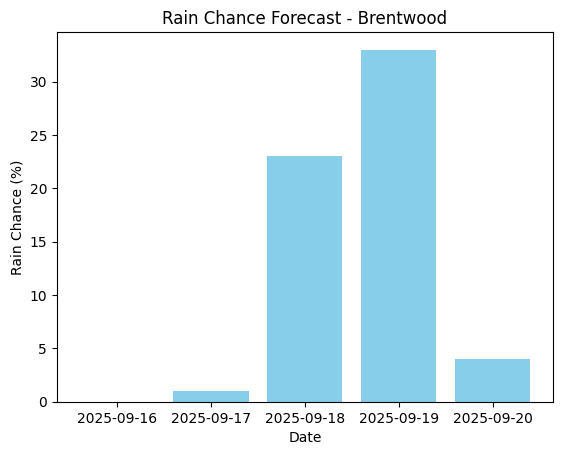

Please select one of the following:
1. View Forecast
2. Ask a Question
3. Visualise Data
4. Exit


In [ ]:
# Include sample input/output for each function
run_app ()


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.